# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
from bootstrap import btset_cd, generateplots, btShInh


# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("Basic2.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="DendE",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="DendN",locus=3,L=240.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())


	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 6283.185307179586
Topology:

|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
         `|       DendN(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Recording places

We set recording vectors in all dendritic compartments, spine included

In [2]:
nsp = 1000
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']*2
sis['Rneck'] = sis['Rneck']*2
sps['Rneck'] = sps['Rneck']*2
#generateplots(dis,corplot=True)

In [3]:
#nsp = 1000
#figure()
iPSDsh = btShInh(size=nsp)
#h = hist(iPSDsh,31)
#xlabel("iPSD shaft ($\mu m^2$)",fontsize=14)


In [4]:

rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*2/5.0
gtrN = rhNMDAR*30e-6/16.0

figureplot=False
if figureplot:
    fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
    fig.suptitle("Number of Receptors",fontsize = 20)

    ax[0].hist(sis['A1']*rhAMPAR,31)
    ax[0].set_xlabel("#AMPAR in Sis")
    ax[1].hist(dis['A1']*rhAMPAR,31)
    ax[1].set_xlabel("#AMPAR in Dis")
    ax[2].hist(dis['A2']*rhGABAR,31)
    ax[2].set_xlabel("#GABAAR in Dis")
    ax[3].hist(iPSDsh*rhGABAR,31)
    ax[3].set_xlabel("#GABAAR in shaft")

    fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
    fig.suptitle("Max Current",fontsize = 20)


    ax[0].hist(sis['A1']*gtrA/1e-6,31)
    ax[0].set_xlabel("I$_{max}$ (pA)")
    ax[1].hist(dis['A1']*gtrA/1e-6,31)
    ax[1].set_xlabel("I$_{max}$ (pA)")
    ax[2].hist(dis['A2']*gtrG/1e-6,31)
    ax[2].set_xlabel("I$_{max}$ (pA)")
    ax[3].hist(iPSDsh*gtrG/1e-6,31)
    ax[3].set_xlabel("I$_{max}$ (pA)")
    #savefig("D_maxI.png",bbox_inches='tight',pad_inches = 0)


In [5]:
figureplot=False
if figureplot:
    spn = sis
    plot(spn['D'],spn['L'],'.',alpha=0.5)
    spn = dis
    plot(spn['D'],spn['L'],'.',alpha=0.5)
    xlabel("Diameter")
    ylabel('Length')

    #figure()
    #plot(spn['D']**2*pi*spn['L']/4,spn['Vh'],'.')
    figure()
    hist(spn['Ah']/(spn['D']*pi*spn['L']),51)

In [6]:
for dend in model.dend:
    print(dend.L,dend.diam)

1.0 1.5
200.24984394500785 1.5000000000000002
50.15974481593781 1.5
4.0 1.5
200.0 10.0


In [7]:
sp = model.spne[0]
print(sp(0.5).area(),sp(0.5).volume(),sp.diam*sp.L*pi,sp.diam**2*sp.L*pi/4.0)

sp.L = dis["L"][0]
sp.diam = dis["D"][0]
print("Area Volume Ah Vh")
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])


3.141592653589793 0.7853981633974483 3.141592653589793 0.7853981633974483
Area Volume Ah Vh
1.52826941444523 0.2659538803220842 1.5282694144452298 0.2659538803220842


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [8]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.5
tau2 = 3.0
AMPA.tau1 = tau1
AMPA.tau2 = tau2

nampa = 50
gmax = 15*nampa/1e6
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = 50*nnmda/1e6
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = 2.0
NMDA.tau2 = 30.0


### Inhibitory synapse

In [9]:
nGABA = 35
gmaxG = nGABA*30e-6
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  
#GABA = model.GABAlist[0]
#NCG = model.ncGABAlist[0]
#stimG=lb.h.NetStim();stimG.number = 1;
#NCG = lb.h.NetCon(stimG,GABA,0,0,gmaxG)
#model.ncGABAlist[0] = NCG

In [10]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

In [11]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 


Vector[16]

In [12]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [13]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [14]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

In [15]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]
currentGABA = iRec[1]

In [16]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[38]

In [17]:
dendsizeL0 = 10
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),178)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.7
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-2]
dend.diam = 0.7
dendsh = model.dend[-2]
dend.L = 1
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

10.0 1.0
186.4762039205707 0.699999988079071 31.830988618379067
1.0 0.7 637.5169199207984
The resistance of neck and the dendritic impedance are 141.47 and 641 MΩ (resp.)


In [18]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]
dendN.L = 1

In [19]:
dendsh.diam = 0.7
dendc.diam = 0.7
dendN.diam = 0.7        

In [20]:
rhosp = 1.3
dendareaperL = rhosp*mean(sps['Ah'])+(pi*0.5)
factor = dendareaperL/(pi*0.5)
print(factor)
dendN.cm = 3.5
dendc.cm = 3.5

3.6419334535814754


In [21]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1

dendc.nseg = 10
dendN.nseg = 10
print(dendc.nseg,dendN.nseg)

10 10


In [22]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

## Plots

xkcd is to give it non serious appearance

In [23]:
gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*3/5.0
gtrN = rhNMDAR*30e-6*1.0/16.0/4.0/1.27*5*50

In [24]:
diam0 = 0.15
Rneck0 = Rneck/1e6
Cm0 = model.CM
print(Rneck0)

141.4710605261292


In [25]:
Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
print(Rneck)

141.4710605261292


In [26]:
def simulateSet(model,spn,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr = None,VDCC = array([0.,0,0,0]), dendrec = True):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"]))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        posD = data[i,4]
        
        dendc.L = posD-dshL/2
        dendN.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendc.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendc(f)._ref_v)
            else:
                vDendEL[il].record(dendc(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendc.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendN(f)._ref_v)
            else:
                vDendEL2[il].record(dendN(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
        

                    
        #print(data[i,:])
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[1])-array(vrec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,max(vDendRec[3])-EL,max(vrec)-EL,max(cat)-cat[0],array(currentGABA)[aG],array(currentAMPA)[aA],spvol,max(current)]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,array(trec))

In [27]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [28]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa, dendrec=False)
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])

In [29]:
from scipy.integrate import simps

In [30]:
def itertis(t1,t2,A1,A2):
    te = t1*t2/(t1-t2)
    numtt = (t2/t1)**(te/t1)-(t2/t1)**(te/t2)
    t1 = t2 + numtt*A1
    t2 = A2/log(t1/t2)*(t1-t2)/t1
    return(t1,t2)
def gettimes(As,t1 = 10,t2 = 1, n = 1000,tol = 1e-9):
    A1, A2 = As
    t1a, t2a = t1, t2
    for i in range(n):
        t1,t2 = itertis(t1,t2,A1,A2)
    
        if (t1-t1a)**2/t1**2+(t2-t2a)**2/t2**2<tol:
            #print(i)
            break
        t1a, t2a = t1, t2
        #print(t1,t2)
    if i>=n: 
        print('No convergence?')
        
    return(t1,t2)

In [31]:
#arange(trec.shape[0])[trec>50+100][0]

In [32]:
#vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

In [33]:
#plot(trec,Ctracs[:,1])
#def get_ftimes(vtt,ton = 0):
    

In [34]:
def get_atimes(vtt,ton = 3000):
    ampv = vtt.max(axis=0)
    intv = array(list(map(lambda x: simps(x,trec),vtt.transpose())))
    tt = intv/ampv
    sel = vtt.argmax(axis=0)
    trise = (sel-ton)*lb.h.dt
    times = array(list(map(gettimes,column_stack((tt,trise)))))
    return(times, tt, trise)

def get_FWHMtimes(vtt,v0 = None,dt =0.05):
    if v0 is None:
        v0 = vtt[0]
    ampv = vtt.max(axis=0,keepdims=True)-v0
    ampv2 = ampv/2+v0
    sel = ((vtt-ampv2)>0).transpose() 
    times = array(list(map(lambda x: [arange(len(x))[x][0],arange(len(x))[x][-1]],sel)))
    times = dt*(times[:,1]-times[:,0])
    return(times)

In [35]:
def getint(x):
    xc = x*1.0
    xc.sort()
    sh = xc.shape[0]
    xmed = xc[sh//2]
    s0= int(sh*(1-.6827)/2)
    s1 = sh-s0
    x0 = xc[s0]
    x1 = xc[s1]
    s0b= int(sh*(1-.95)/2)
    s1b = sh-s0b
    x0b = xc[s0b]
    x1b = xc[s1b]
    return((xmed,x0,x1,x0b,x1b))

In [49]:
nsp = 500
sps = btset_cd(cd='Sp',size=nsp)

sps['Rneck'] = sps['Rneck']*2
#generateplots(dis,corplot=True)
sps['A2'] = 0.0*sps['A1']

In [50]:
Dssoriginal = 1.0*sps['Dss']

In [51]:
dists = arange(20,150,10)
data = zeros((len(dists),20))
data2 = zeros((len(dists),20))
dtime = zeros((len(dists),5))

times_biexp = False

sps['Dss'] = 10.0+0.*Dssoriginal

EL0 = -70
vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,sps,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracsS0-EL0,0,100)
if times_biexp:
    times0 = get_atimes(vtt,ton=3000)
else:
    times0, tt, trise = get_atimes(vtt,ton=3000)
    times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)


for i,dst in enumerate(dists):
    sps['Dss'] = dst+0.*Dssoriginal
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,sps,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
    
    # EPSP In the soma
    vtt = clip(vtracsS-EL0,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

    #dtime[i,6:8] = (times.mean(),times.std())
    dtime[i,:] = getint(times/times0)
    

    # Statistics
    #data[i,:] = mes.mean(axis=0)
    #datt0 = mes[:,1:5]/mes0[:,1:5]
    #data2[i,:] = concatenate((datt0.mean(axis=0),datt0.std(axis=0)))
    for j in range(1,5):
        data[i,(5*(j-1)):(5*(j))] = getint(mes[:,j])
        data2[i,(5*(j-1)):(5*(j))] = getint(mes[:,j]/mes0[:,j])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [69]:
from scipy.stats import linregress

123.69963615177595


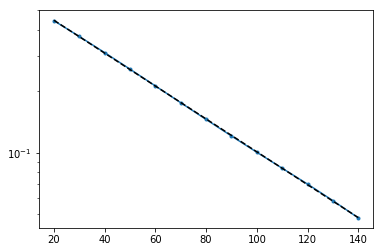

In [75]:
miny = 0.47
plot(dists,data2[:,0+5*2]-miny,'.-')
yscale('log')
x = dists*1.0
y = log10(data2[:,0+5*2]-miny)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
plot(dists,10**(dists*slope+intercept),'k--')
print(-1.0/slope)

In [76]:
isnan(sps['A2']).sum()

0

In [78]:
with open("inhibition_corlengthx2.pickle","wb") as f:
    pickle.dump([dists,data2,data,dtime],f)